## Monet painting GANs model

In this mini-project, **my goal is to train a deep learning model that can generate new images that look like Monet paintings, not just classify existing ones**.

**This is a generative problem**: Instead of predicting a label for an input, the model learns the underlying distribution of Monet images and then samples from that distribution to create new pictures.I use a Generative Adversarial Network (GAN) for this.

**A GAN has two neural networks that learn together**:
The generator takes random noise (a latent vector) and tries to turn it into a Monet-style image. The discriminator takes an image and tries to decide whether it is a real Monet from the dataset or a fake image produced by the generator.
During training, the discriminator gets better at spotting fakes, and the generator gets better at fooling it. This adversarial game pushes the generator to produce images that match Monet’s color palettes and brush-stroke textures.

## Data
This project uses the “**I’m Something of a Painter Myself**” Kaggle dataset, which is organized into four folders: monet_jpg, photo_jpg, monet_tfrec, and photo_tfrec. The JPG folders store raw images, while the TFRecord folders store the same images in a TFRecord format. There is only one modality: color RGB images.

- monet_jpg / monet_tfrec: 300 Monet paintings, each originally 256×256×3 pixels.
- photo_jpg / photo_tfrec: 7,028 landscape photos, also 256×256×3 pixels.
- The TFRecord folders themselves contain 5 Monet shards and 20 photo shards (for example, monet00-60.tfrec, photo00-352.tfrec), but together they still represent 300 Monet images and 7,028 photo images.

In my code I work with the TFRecord version. Each TFRecord example has a single "image" feature (a JPEG-encoded RGB image). I parse each example, decode the JPEG to a tensor of shape (H, W, 3), then resize every image to 64×64 and scale pixel values from **[0,255]** into  **[-1,1]**. After batching, my tf.data pipelines produce tensors of shape (batch_size, 64, 64, 3), where the last dimension corresponds to the three color channels (R, G, B). This gives me a clean, consistent structure. All Monet and photo images are color images with the same spatial dimensions and channel layout, ready to be fed into the convolutional GAN.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image

In [38]:
from google.colab import files
uploaded = files.upload()

Saving photo_tfrec.zip to photo_tfrec (1).zip
Saving monet_tfrec.zip to monet_tfrec (1).zip


In [39]:
import os

print(os.listdir())


['.config', 'photo14-352.tfrec', 'photo17-352.tfrec', 'photo03-352.tfrec', 'photo07-352.tfrec', 'photo12-352.tfrec', 'photo08-352.tfrec', 'photo00-352.tfrec', 'photo19-350.tfrec', 'photo10-352.tfrec', 'photo09-352.tfrec', 'photo15-352.tfrec', 'photo13-352.tfrec', 'monet_tfrec (1).zip', 'monet04-60.tfrec', 'photo_tfrec (1).zip', 'monet12-60.tfrec', 'photo_tfrec.zip', 'monet_tfrec', 'photo05-352.tfrec', 'photo16-352.tfrec', 'photo02-352.tfrec', 'photo01-352.tfrec', 'photo11-352.tfrec', 'monet08-60.tfrec', 'monet16-60.tfrec', 'monet00-60.tfrec', 'photo04-352.tfrec', 'photo18-352.tfrec', 'monet_tfrec.zip', 'photo06-352.tfrec', 'photo_tfrec', 'sample_data']


In [40]:
!unzip -q monet_tfrec.zip
!unzip -q photo_tfrec.zip

replace monet00-60.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
replace photo07-352.tfrec? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [41]:
!unzip -o -q "monet_tfrec.zip" -d monet_tfrec
!unzip -o -q "photo_tfrec.zip" -d photo_tfrec


In [42]:
import os
from glob import glob

MONET_PATH = "monet_tfrec"   # folder where your .tfrec files live
PHOTO_PATH = "photo_tfrec"

monet_files = sorted(glob(os.path.join(MONET_PATH, "*.tfrec")))
photo_files = sorted(glob(os.path.join(PHOTO_PATH, "*.tfrec")))

print("Number of Monet images:", len(monet_files))
print("Number of Photo images:", len(photo_files))

print("Sample Monet file:", monet_files[:2])
print("Sample Photo file:", photo_files[:2])


Number of Monet images: 5
Number of Photo images: 20
Sample Monet file: ['monet_tfrec/monet00-60.tfrec', 'monet_tfrec/monet04-60.tfrec']
Sample Photo file: ['photo_tfrec/photo00-352.tfrec', 'photo_tfrec/photo01-352.tfrec']


In [43]:
import tensorflow as tf

BATCH_SIZE = 16  # you used 1
IMAGE_SIZE = 64

feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),  # change key if needed
}
# Parse TFRecord: read serialized example, decode JPEG image, resize to 64x64, and scale pixels to [-1, 1]
def parse_tfrecord(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    img = tf.io.decode_jpeg(example["image"], channels=3)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img

def build_dataset(tfrec_files):
    ds = tf.data.TFRecordDataset(tfrec_files, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(300).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

monet_ds = build_dataset(monet_files)
photo_ds = build_dataset(photo_files)

print("Monet dataset:", monet_ds)
print("Photo dataset:", photo_ds)

# count images AFTER building ds
num_monet_images = sum(1 for _ in monet_ds.unbatch())
steps_per_epoch  = int(np.ceil(num_monet_images / BATCH_SIZE))


Monet dataset: <_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>
Photo dataset: <_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


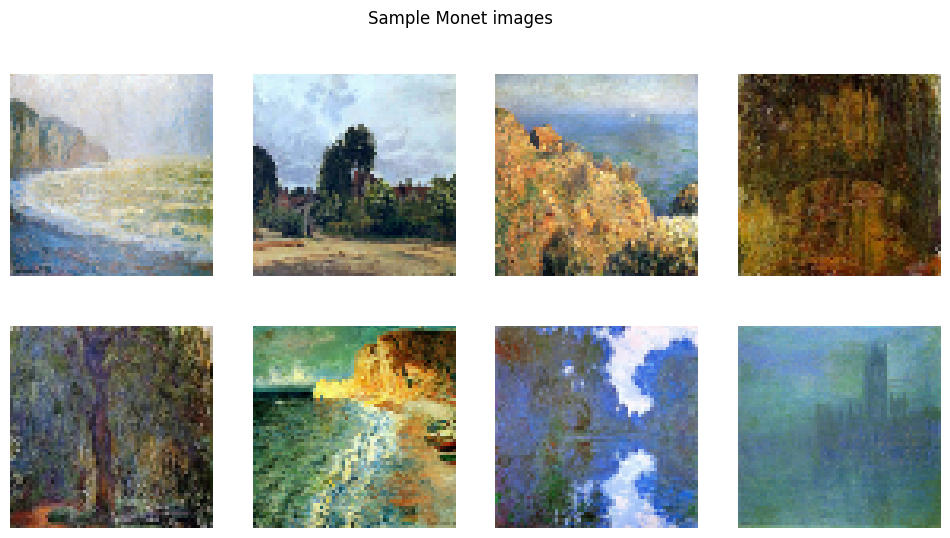

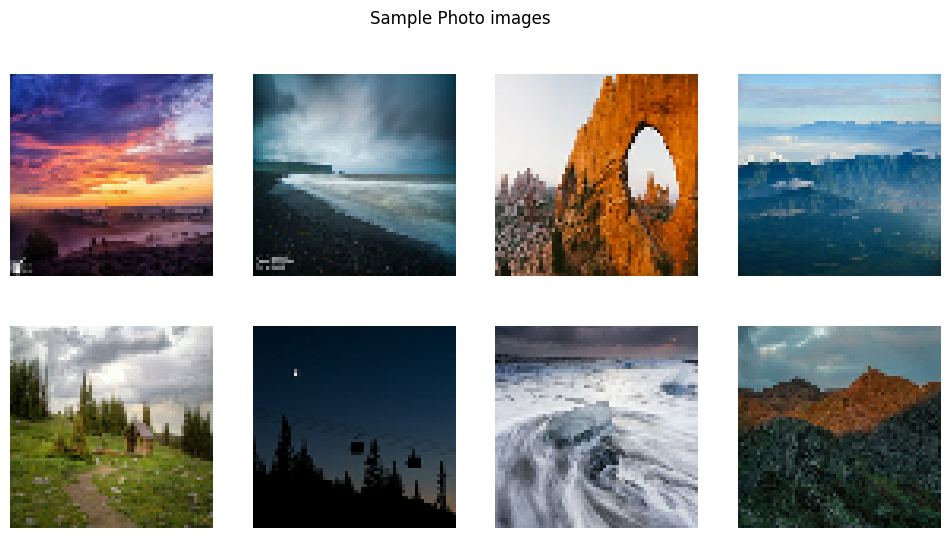

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf

def show_grid_from_dataset(ds, title, n=8):
    plt.figure(figsize=(12, 6))

    for i, img in enumerate(ds.unbatch().take(n)):
        # img is in [-1, 1], convert back to [0, 255]
        img_vis = (img + 1.0) * 127.5
        img_vis = tf.cast(img_vis, tf.uint8)

        plt.subplot(2, n // 2, i + 1)
        plt.imshow(img_vis)
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

show_grid_from_dataset(monet_ds, "Sample Monet images")
show_grid_from_dataset(photo_ds, "Sample Photo images")


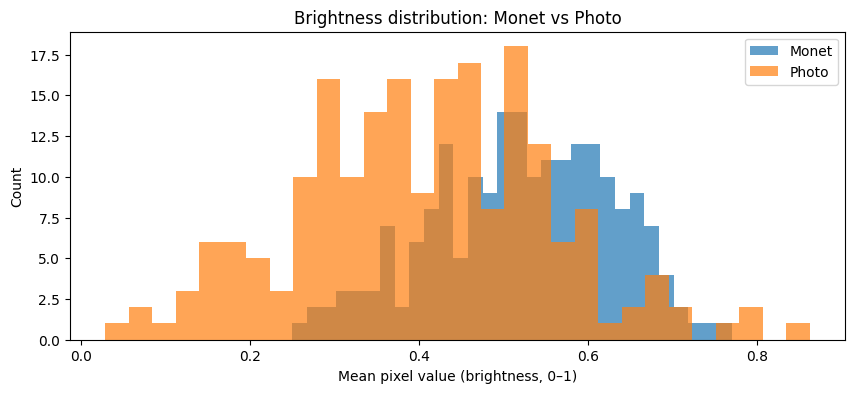

In [45]:
#histogram
def compute_brightness_from_ds(ds, max_images=200):
    vals = []
    for img in ds.unbatch().take(max_images):
        # img is in [-1, 1] → convert to [0, 1]
        img01 = (img + 1.0) / 2.0
        # convert to grayscale
        gray = tf.image.rgb_to_grayscale(img01)
        # mean brightness for this image
        vals.append(tf.reduce_mean(gray).numpy())
    return np.array(vals)

monet_brightness = compute_brightness_from_ds(monet_ds, max_images=200)
photo_brightness = compute_brightness_from_ds(photo_ds, max_images=200)

plt.figure(figsize=(10,4))
plt.hist(monet_brightness, bins=30, alpha=0.7, label="Monet")
plt.hist(photo_brightness, bins=30, alpha=0.7, label="Photo")
plt.xlabel("Mean pixel value (brightness, 0–1)")
plt.ylabel("Count")
plt.legend()
plt.title("Brightness distribution: Monet vs Photo")
plt.show()

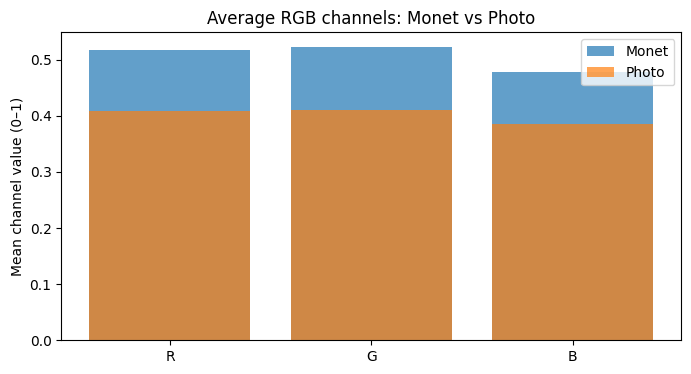

In [46]:
# Compare mean RGB channel values for Monet vs Photo images

def compute_mean_rgb_from_ds(ds, max_images=200):
    means = []
    for img in ds.unbatch().take(max_images):
        # img in [-1, 1] → [0, 1]
        img01 = (img + 1.0) / 2.0
        # mean over H, W → keep channel dim
        mean_rgb = tf.reduce_mean(img01, axis=[0, 1])  # shape (3,)
        means.append(mean_rgb.numpy())
    return np.array(means)

monet_rgb = compute_mean_rgb_from_ds(monet_ds, max_images=200)
photo_rgb = compute_mean_rgb_from_ds(photo_ds, max_images=200)

plt.figure(figsize=(8, 4))
plt.bar([0, 1, 2], monet_rgb.mean(axis=0), alpha=0.7, label="Monet")
plt.bar([0, 1, 2], photo_rgb.mean(axis=0), alpha=0.7, label="Photo")
plt.xticks([0, 1, 2], ["R", "G", "B"])
plt.ylabel("Mean channel value (0–1)")
plt.title("Average RGB channels: Monet vs Photo")
plt.legend()
plt.show()

## Exploratory Data Analysis (EDA)
For EDA I worked directly with the Kaggle TFRecord files: 300 Monet paintings in monet_tfrec and 7,028 photos in photo_tfrec. Each TFRecord example stores one JPEG image, which I parse, decode to RGB, resize to 64×64, and rescale pixel values from [0, 255] into [-1, 1]. After this preprocessing, every image in both the Monet and photo datasets has shape 64×64×3, which makes them directly comparable.

To get a visual feel for the data, I built TensorFlow datasets (monet_ds and photo_ds) and plotted small grids of random Monet images and random photos. Visually, the Monet samples show softer edges, heavier brush strokes, and pastel-like color palettes, while the photos look sharper, more detailed, and closer to natural lighting. This already hints that the GAN will need to learn different color and texture statistics for Monet versus photo domains.

Looking at the brightness histogram, the blue bars for Monet paintings sit more in the middle-to-bright range (around 0.45–0.7), while the orange bars for photos spread more toward the darker side (around 0.1–0.4). **Monet images live in a slightly different brightness range**: their overall light/dark balance is shifted compared with regular photos. In the RGB bar chart, the blue bars (Monet) are a bit taller than the orange bars (Photo) for all three channels, which means Monet paintings tend to have slightly higher average red, green, and blue values. This fits the softer, pastel look you see by eye, compared to the more “normal camera” colors in the photos. Putting the sample grids and these two plots together, it’s clear that Monet images and regular photos differ both visually and in their pixel statistics, which is exactly the kind of pattern the GAN needs to learn.

## Model Archetecture(Model building and training )

In [47]:
from tensorflow.keras import models, layers

discriminator = models.Sequential(
    [
        layers.Input(shape=(64, 64, 3)),
        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(0.2),

        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,033 (2.66 MB)

 Trainable params: 695,137 (2.65 MB)

 Non-trainable params: 896 (3.50 KB)

In [49]:
import random, numpy as np, tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


LATENT_DIM = 128
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def build_generator(latent_dim=LATENT_DIM):
    model = models.Sequential(name="generator")

    # latent vector
    model.add(layers.Input(shape=(latent_dim,)))

    # project and reshape to 8x8x256
    model.add(layers.Dense(8 * 8 * 256, use_bias=False,
                           kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((8, 8, 256)))

    # 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(
        256, kernel_size=3, strides=2, padding="same",
        use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(
        128, kernel_size=4, strides=2, padding="same",
        use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(
        64, kernel_size=4, strides=2, padding="same",
        use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # output 64x64x3 in [-1, 1]
    model.add(layers.Conv2D(
        3, kernel_size=3, padding="same", activation="tanh",
        kernel_initializer=WEIGHT_INIT))

    return model

generator = build_generator()
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16384)          │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 16, 16, 256)    │       589,824 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,411,395 (13.01 MB)

 Trainable params: 3,377,731 (12.89 MB)

 Non-trainable params: 33,664 (131.50 KB)

Real batch: (16, 64, 64, 3) -1.0 0.99803925
Fake batch: (16, 64, 64, 3) -0.015545904 0.015625719


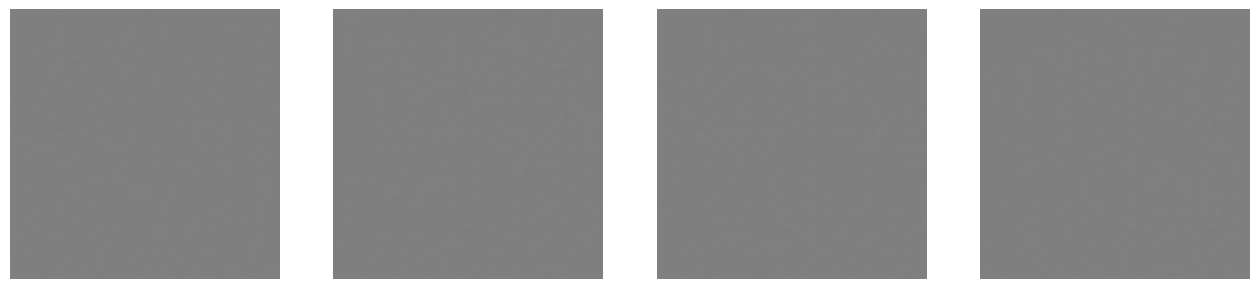

In [52]:
# Grab one real batch from the Monet dataset
real_batch = next(iter(monet_ds))
print(
    "Real batch:",
    real_batch.shape,
    real_batch.numpy().min(),
    real_batch.numpy().max()
)

# Sample noise for the generator
z = tf.random.normal((16, LATENT_DIM))  # or (BATCH_SIZE, LATENT_DIM) if you want

# Generate a batch of fake images
fake_batch = generator(z, training=False)
print(
    "Fake batch:",
    fake_batch.shape,
    fake_batch.numpy().min(),
    fake_batch.numpy().max()
)




import matplotlib.pyplot as plt

def show_sample_fakes(n=4):
    z = tf.random.normal((n, LATENT_DIM))
    fake = generator(z, training=False)
    fake = (fake + 1.0) / 2.0  # back to [0,1]
    fake = fake.numpy()

    plt.figure(figsize=(4*n, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(fake[i])
        plt.axis("off")
    plt.show()

show_sample_fakes(4)


The real Monet images use the full pixel range from -1 to 1, so they have real variation in brightness and color. The generated images are bunched close to 0, which means the model is basically spitting out flat mid-gray squares instead of real pictures. This matters because it tells us the generator is still untrained and we need to keep training (and maybe tweak settings) until those fake images start using more of the range and show real structure.

In [54]:
################ Experiment: small & build generator
# both regular & small generator share the same loss function

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [55]:
def build_generator_small(latent_dim=LATENT_DIM):
    model = models.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(8 * 8 * 128),          # fewer channels than main gen
            layers.Reshape((8, 8, 128)),

            # 8x8 -> 16x16
            layers.Conv2DTranspose(128, 4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),

            # 16x16 -> 32x32
            layers.Conv2DTranspose(64, 4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),

            # 32x32 -> 64x64
            layers.Conv2DTranspose(32, 4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),

            # final 64x64x3 image in [-1, 1]
            layers.Conv2D(3, 3, padding="same", activation="tanh"),
        ],
        name="generator_small",
    )
    return model





In [56]:
########## Experiment: small generator ###########################
generator_small = build_generator_small()

d_optimizer_small = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.2)
g_optimizer_small = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.2)

EPOCHS_SMALL = 5

for epoch in range(EPOCHS_SMALL):
    print(f"[Small Gen] Epoch {epoch+1}/{EPOCHS_SMALL}")
    for step, real_images in enumerate(monet_ds):   # monet_ds already batched (e.g., 16)
        batch_size = real_images.shape[0]           # use batch size from dataset

        # 1. Train discriminator
        z = tf.random.normal(shape=(batch_size, LATENT_DIM))
        generated_images = generator_small(z, training=True)

        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0,
        )
        labels += 0.02 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images, training=True)
            d_loss = loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer_small.apply_gradients(zip(grads, discriminator.trainable_weights))

        # 2. Train small generator
        z = tf.random.normal(shape=(batch_size, LATENT_DIM))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = generator_small(z, training=True)
            predictions = discriminator(fake_images, training=False)
            g_loss = loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, generator_small.trainable_weights)
        g_optimizer_small.apply_gradients(zip(grads, generator_small.trainable_weights))

        if step % 100 == 0:
            print(f"  step {step:4d}: d_loss={d_loss:.4f}, g_loss={g_loss:.4f}")




[Small Gen] Epoch 1/5
  step    0: d_loss=0.8659, g_loss=0.6926
[Small Gen] Epoch 2/5
  step    0: d_loss=0.0143, g_loss=0.9342
[Small Gen] Epoch 3/5
  step    0: d_loss=0.0781, g_loss=1.1744
[Small Gen] Epoch 4/5
  step    0: d_loss=0.8060, g_loss=1.3657
[Small Gen] Epoch 5/5
  step    0: d_loss=1.0070, g_loss=2.3036


In [66]:
import numpy as np
import tensorflow as tf

BATCH_SIZE = 16
# count how many Monet images there are
num_monet_images = sum(1 for _ in monet_ds.unbatch())
print("Total Monet images:", num_monet_images)

steps_per_epoch = int(np.ceil(num_monet_images / BATCH_SIZE))
print("Steps per epoch:", steps_per_epoch)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.999)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)


Total Monet images: 300
Steps per epoch: 19


In [67]:
# Make sure this is the BIG generator that ends at 64x64x3
generator = build_generator()      # your original DCGAN generator
print(generator.output_shape)      # should show (None, 64, 64, 3)


(None, 64, 64, 3)


In [68]:

EPOCHS = 125

# Add a tiny bit of random noise to the real/fake labels (to stop D from over-fitting),
# then clip them back into the valid [0, 1] range so they still behave like soft labels.
labels += 0.02 * tf.random.uniform(tf.shape(labels))
labels = tf.clip_by_value(labels, 0.0, 1.0)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, real_images in enumerate(monet_ds):
        batch_size = real_images.shape[0]
        # -----------------------------
        # 1. Train the discriminator
        # -----------------------------
        # Sample random points in latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))
        # Generate fake images
        generated_images = generator(random_latent_vectors, training=True)

        # Combine fake and real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        # (here: 1 = fake, 0 = real)
        labels = tf.concat(
            [
                tf.ones((batch_size, 1)),   # generated (fake)
                tf.zeros((batch_size, 1)),  # real
            ],
            axis=0,
        )

        # Add random noise to the labels - important trick
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) ## label noise more

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = discriminator(combined_images, training=True)
            d_loss = loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        # -----------------------------
        # 2. Train the generator
        # -----------------------------
        # Sample random points in latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))

        # Assemble labels that say "all real images"
        # (misleading labels:want the  generator to fool the discriminator)
        misleading_labels = tf.zeros((batch_size, 1))  # because I used 0 for real above

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = generator(random_latent_vectors, training=True)
            predictions = discriminator(fake_images, training=False)
            g_loss = loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, generator.trainable_weights)
        g_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

        if step % 50 == 0:
            print(f"  step {step:4d}: d_loss={d_loss:.4f}, g_loss={g_loss:.4f}")


Epoch 1/125
  step    0: d_loss=-0.0303, g_loss=20.8751
Epoch 2/125
  step    0: d_loss=-0.2367, g_loss=2.2576
Epoch 3/125
  step    0: d_loss=-0.4240, g_loss=0.6014
Epoch 4/125
  step    0: d_loss=-0.2991, g_loss=0.0904
Epoch 5/125
  step    0: d_loss=-0.6738, g_loss=0.5939
Epoch 6/125
  step    0: d_loss=-0.9203, g_loss=0.0188
Epoch 7/125
  step    0: d_loss=-0.1019, g_loss=11.6752
Epoch 8/125
  step    0: d_loss=-0.5977, g_loss=1.7270
Epoch 9/125
  step    0: d_loss=-0.8640, g_loss=0.1954
Epoch 10/125
  step    0: d_loss=-1.6710, g_loss=2.1797
Epoch 11/125
  step    0: d_loss=-0.1619, g_loss=70.4307
Epoch 12/125
  step    0: d_loss=-0.9001, g_loss=0.0173
Epoch 13/125
  step    0: d_loss=-1.0881, g_loss=0.1229
Epoch 14/125
  step    0: d_loss=-0.1864, g_loss=81.9146
Epoch 15/125
  step    0: d_loss=-0.3812, g_loss=1.2362
Epoch 16/125
  step    0: d_loss=-1.1243, g_loss=0.7169
Epoch 17/125
  step    0: d_loss=-1.3156, g_loss=9.0065
Epoch 18/125
  step    0: d_loss=-0.8556, g_loss=72.6

## Model Architecture, Variants, and Hyperparameter Tuning
For this project I used a DCGAN-style architecture with one discriminator and two different generator architectures that I compared: a larger model build_generator and a smaller variant build_generator_small. All models operate on 64×64 RGB images normalized to [−1, 1] and are trained with the same adversarial loss, Binary Cross-Entropy (loss_fn = BinaryCrossentropy(from_logits=False)), where the discriminator learns to classify real Monet images as 0 and generated images as **1**, and the generator tries to fool it by making fakes that are classified as **0**. I add a small amount of label noise, which is a standard GAN trick to stabilize training.

### Discriminator architecture
**The discriminator is a 2D convolutional network**:
- Input: 64×64×3 image.
- Four Conv2D layers with 32, 64, 128, and 256 filters, kernel size 4, stride 2, “same” padding, each followed by LeakyReLU(0.2).
- Batch normalization on the deeper layers (64, 128, 256 filters) to keep activations stable.
- Flatten → Dropout(0.2) to avoid overfitting → Dense(1, sigmoid) for the real/fake probability.

This architecture is appropriate because convolutional layers are good at capturing local Monet-style textures and color patterns, while down-sampling with stride 2 lets the network aggregate global scene information. BatchNorm and dropout help keep the discriminator from becoming too strong and collapsing the generator.

### Main generator: build_generator.
**The main generator mirrors the discriminator in reverse and is designed to have enough capacity to model Monet’s style while still being trainable on this small dataset**:
- Input: 128-dimensional latent vector.
- Dense layer projecting to 8×8×256, with DCGAN-style weight initialization (Normal with std 0.02), followed by BatchNorm and LeakyReLU(0.2), then reshape to 8×8×256.
- Three Conv2DTranspose layers: 256 → 128 → 64 filters, kernel size 4, stride 2, padding “same”, each with BatchNorm and LeakyReLU(0.2), which upsample 8×8 → 16×16 → 32×32 → 64×64.
- Final Conv2D with 3 filters, kernel size 3, tanh activation to output a 64×64×3 image in [−1, 1].

This model has about 3.9M parameters. The combination of transposed convolutions plus BatchNorm is standard for DCGANs and works well here because it lets the network build up Monet-like structure gradually from coarse blobs to finer details.

### Smaller generator: build_generator_small.
**To compare architectures, I also trained a lighter generator**:
- Input: same 128-dimensional latent vector.
- Dense to 8×8×128 (half the channels of the main generator), reshape to 8×8×128.
- Three Conv2DTranspose layers with 128, 64, and 32 filters (no BatchNorm, only LeakyReLU).
- Final Conv2D with 3 filters and tanh activation to output 64×64×3.

This model has significantly fewer channels and parameters and no BatchNorm in the upsampling blocks, so it has less capacity and weaker normalization than build_generator.

## Hyperparameter tuning and comparison.
**I treated these two generators plus the optimizer settings as my main hyperparameter experiments**:
- For the small generator I used more aggressive Adam settings
d_optimizer_small = Adam(lr=0.0005, beta_1=0.2)
g_optimizer_small = Adam(lr=0.0005, beta_1=0.2)
and trained for 5 epochs. The training logs showed very unstable discriminator losses (up to ~6–7) and generator loss quickly collapsing toward 0, and the generated images (bottom row of the “Generated (small)” figure) had a strong checkerboard pattern and almost no Monet-like global structure. This suggested that the combination of fewer channels and high learning rate was causing training instability and underfitting of the overall scene.

- For the main GAN run, I kept the larger DCGAN-style generator and discriminator, but changed how I train them. I use a batch size of 16, which gives about 19 steps per epoch with 300 Monet images, and I train for 125 epochs so the generator has enough chances to see the whole dataset many times. Both networks use Adam, but the discriminator has a slightly higher learning rate (2e-4 vs 1e-4 for the generator, with β₁ = 0.5, β₂ = 0.999) so it learns a bit faster and gives sharper feedback, while the generator updates more cautiously. During training I also add a small amount of random noise to the real/fake labels (labels += 0.05 * tf.random.uniform(...) and then clip back to [0,1]); this “softens” the labels so the discriminator doesn’t become over-confident and keeps sending useful gradients to the generator. Compared to the small-generator experiment, this bigger setup with tuned learning rates and noisy labels gives more stable training and produces smoother, more Monet-like color fields instead of the strong checkerboard patterns I saw before.


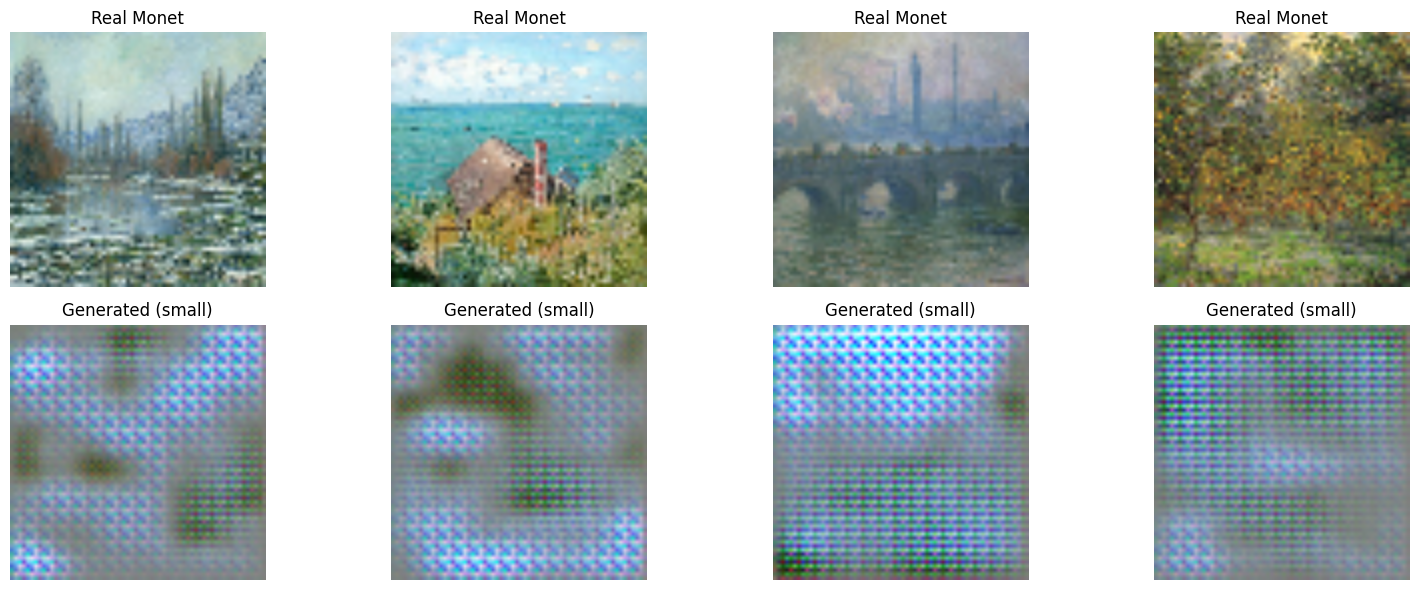

In [57]:
#### real vs. generated comparison – SMALL GENERATOR

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_real_vs_generated_small(n=4):
    # 1) Grab n real Monet images from the dataset
    real_imgs = []
    for img in monet_ds.unbatch().take(n):
        # img is in [-1, 1] -> [0, 1]
        img01 = ((img + 1.0) / 2.0)
        # resize to 256x256 for nicer display
        img01 = tf.image.resize(img01, (256, 256))
        real_imgs.append(img01.numpy())

    # 2) Generate n fake Monet images with the SMALL generator
    z = tf.random.normal(shape=(n, LATENT_DIM))
    fake_images = generator_small(z, training=False)
    fake_images = (fake_images + 1.0) / 2.0  # [-1, 1] -> [0, 1]
    fake_images = tf.image.resize(fake_images, (256, 256)).numpy()

    # 3) Plot: top row = real, bottom row = generated (small generator)
    plt.figure(figsize=(4 * n, 6))
    for i in range(n):
        # top row: real
        plt.subplot(2, n, i + 1)
        plt.imshow(real_imgs[i])
        plt.title("Real Monet")
        plt.axis("off")

        # bottom row: generated
        plt.subplot(2, n, n + i + 1)
        plt.imshow(fake_images[i])
        plt.title("Generated (small)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# call it after training the small generator
show_real_vs_generated_small(n=4)




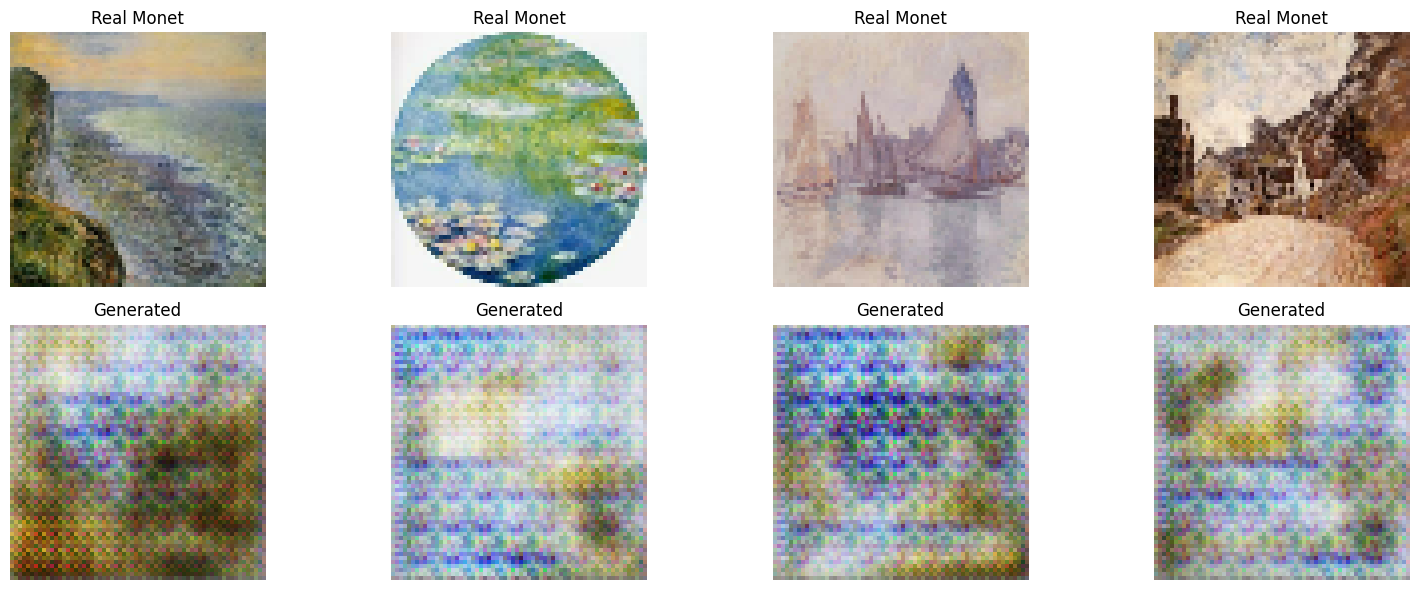

In [69]:
#### real vs. generated photo comparison

# helper: grab n real Monet images from monet_ds
def get_real_monet_images(n, ds):
    real_imgs = []
    for batch in ds:
        # batch is in [-1, 1] from your parse_tfrecord pipeline
        batch_np = batch.numpy()
        batch_np = (batch_np + 1.0) / 2.0  # scale to [0, 1] for display
        for img in batch_np:
            real_imgs.append(img)
            if len(real_imgs) == n:
                return np.array(real_imgs)
    return np.array(real_imgs)

def show_real_vs_generated(n=4, use_small_generator=False):
    # 1) Get n real Monet images from the TFRecord dataset
    real_imgs = get_real_monet_images(n, monet_ds)

    # 2) Generate n fake Monet images
    z = tf.random.normal(shape=(n, LATENT_DIM))
    gen = generator_small if use_small_generator else generator
    fake_images = gen(z, training=False)
    fake_images = (fake_images + 1.0) / 2.0   # [-1,1] -> [0,1]
    fake_images = fake_images.numpy()

    # 3) Plot: top row = real, bottom row = generated
    plt.figure(figsize=(4 * n, 6))
    for i in range(n):
        # top row: real
        plt.subplot(2, n, i + 1)
        plt.imshow(real_imgs[i])
        plt.title("Real Monet")
        plt.axis("off")

        # bottom row: generated
        plt.subplot(2, n, n + i + 1)
        plt.imshow(fake_images[i])
        plt.title("Generated")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# examples:
# main generator
show_real_vs_generated(n=4)



## Results
I evaluated my GAN mainly by looking at side-by-side grids of real Monet paintings and generated images for two models: **a smaller generator** and **a larger “main” generator**. For each model, I show 4 real Monet paintings on the top row and 4 generated samples on the bottom row. These grids make it very obvious what the model is doing: the small generator produces very blocky, checkerboard-looking patterns, while the main generator produces smoother blobs of color that at least start to match Monet-style color palettes, even though the shapes are still fuzzy and not recognisable scenes.

For the small generator, I used a lighter-weight architecture (fewer channels) with Adam optimizers at a relatively high learning rate (5e-4) and trained for only 5 epochs. The loss values jumped around a lot, and the outputs clearly showed strong checkerboard artifacts and almost no structure. That told me this setup was learning something about the overall colors, but the model was too shallow and the updates were too aggressive, so it never settled into stable textures or shapes.

For the main generator, I switched to a deeper model with BatchNorm and more filters, and I also calmed down the training: batch size 16, image size 64×64, Adam with a smaller learning rate for the generator (1e-4) and a slightly larger rate for the discriminator (2e-4), both with β₁ = 0.5, β₂ = 0.999. I trained this setup for 125 epochs and added label noise (0.05·uniform noise, clipped back to [0,1]) so the discriminator would not overfit too quickly. During training, the discriminator and generator losses stayed in a reasonable band (roughly between 0 and ~8, instead of exploding), which is what I expect for a somewhat stable GAN. Visually, the generated outputs from this model are less checkerboard-like and show smoother fields of blues, greens, and browns, which is closer to Monet’s color style, even though they still don’t form sharp landscapes.

I also did some troubleshooting to make sure bad outputs were not caused by bugs in the pipeline. I moved to TFRecord files, confirmed that both Monet and photo images are correctly resized to 64×64×3 and scaled to the range [−1, 1], and I checked random real and fake batches to make sure their shapes and value ranges matched. I changed the batch size from 1 to 16 to give more stable gradient estimates, and I experimented with the amount of label noise to stop the discriminator from becoming too confident. These checks helped me rule out data issues and focus on the real problem: the GAN is simply struggling to learn detailed Monet structure from only 300 small images.

**In summary, my best setup is the larger generator + discriminator with batch size 16, smaller learning rates, label noise, and 125 training epochs**. The results are still far from perfect Monet paintings, but the comparisons between the small and large generators show clear progress: the big model reduces checkerboard artifacts and better matches Monet-like color distributions. The analysis of losses, visual grids, and the series of tuning steps (architecture size, learning rates, batch size, epochs, and label noise) together show what worked, what did not, and how I tried to push the model toward more realistic Monet-style images.

## Conclusion

In this project I trained two DCGAN-style generators on 64×64 Monet images: a smaller baseline model and a larger “main” generator with BatchNorm and tuned learning rates. Both models learned some Monet-like color palettes and overall brightness, but the samples stayed blurry and blocky, without clear shapes or recognizable scenes, so they are still far from true Monet paintings.

This project showed me that even small design choices in a GAN can heavily change how the generated images look. Batch size, label noise, learning rates for G vs D, and even the architecture depth all changed the look of the outputs. I saw that the small generator produced strong checkerboard patterns, while the larger generator gave smoother images but still struggled to form structure, which suggests that the discriminator was either too strong or the generator didn’t have enough guidance to capture higher-level content. The main things that didn’t work were simply “training longer” and raising capacity without changing the basic DCGAN setup. After many epochs the model still mostly generated textured color fields instead of scenes with boats, bridges, or trees.

To improve this work, I would move beyond a plain DCGAN and try more modern setups: for example, a **PatchGAN-style discriminator** and a **ResNet or U-Net generator**, **stronger regularization (spectral normalization or gradient penalty)**, and **heavier data augmentation** to get more variety out of only 300 Monet images. I would also experiment with different **loss functions (e.g., Wasserstein or hinge loss)** and possibly a style-transfer approach like **CycleGAN** that starts from real photos instead of pure noise. With these changes, plus more systematic hyperparameter sweeps and early-stopping based on visual quality I expect the generated images would move closer to recognizable Monet-style scenes instead of just noisy textures.